<a href="https://colab.research.google.com/github/noahruiz416/Tempe_Traffic_Classification/blob/main/Tempe_Traffic_Prototype_Feature_Engineering_Model_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook will contain the initial feature engineering approaches that will be used. Decisions to transform or change certain varaibles will be explained

In [24]:
import pandas as pd
import numpy as np 

In [25]:
df = pd.read_csv("traffic_data.2.csv")

#### Based on Exploratory Analysis, I plan on combining certain features that are very similar. Additionally I may exclude certain variables as well. More in depth reasoning will be included in final report.

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#### This first set of functions are to be used as needed, depending on the model being ran

In [27]:
#function to binary encode accidents as fatal or nonfatal
def encode_fatal_accidents(data):
  Severity = []
  for row in data['Injuryseverity']:
    if row != "Fatal":
      Severity.append(0) #nonfatal
    if row == "Fatal":
      Severity.append(1) #fatal
  data['Fatal_Non_Fatal'] = Severity

#this function turns our categorical variables into dummy variables
def nominal_encoding(data):
  data = [['StreetName','Collisionmanner', 'Lightcondition', 'Weather', 'SurfaceCondition']] 
  data_dummies = pd.get_dummies(data)
  return data_dummies

def drop_useless_cols(data):
  return_data = data.drop(labels = ['X', 'Y', 'OBJECTID',
                      'Incidentid', 'DateTime', 'Year',
                       'Latitude', 'Longitude', 'Totalinjuries',
                       'Totalfatalities', 'Injuryseverity', 'Distance'], axis = 1)
  return return_data

In [28]:
#helper function that contains the logic for whether or not drugs were involved in an accident
def label_drugs(row):
  if row['DrugUse_Drv1'] == "Drugs" or row['DrugUse_Drv2'] == "Drugs":
    return 1 #drugs are involved
  if row['DrugUse_Drv1'] != "Drugs" or row['DrugUse_Drv2'] != "Drugs":
    return 0 #drugs are not involved

#helper function that contains the logic for whether or not alch was involved in an accident
def label_alchol(row):
  if row['AlcoholUse_Drv1'] == "Drugs" or row['AlcoholUse_Drv2'] == "Drugs":
    return 1 #drugs are involved
  if row['AlcoholUse_Drv1'] != "Drugs" or row['AlcoholUse_Drv2'] != "Drugs":
    return 0 #drugs are not involved

def apply_drug_alchol_label(input_data):
  data1 = input_data['drugs_involved'] = input_data.apply (lambda row: label_drugs(row), axis=1)
  data1 = input_data['alcohol_involved'] = input_data.apply (lambda row: label_alchol(row), axis=1)


#### These functions are a part of basic data cleaning and will be used for all train datasets regardless of the model

In [29]:
#this function drops bad columns in light conditions, violations and collisionmanner
def drop_useless_rows(input_data):
  data1 = input_data[input_data['Lightcondition'].str.contains("51")==False]
  data2 = data1[data1['Lightcondition'].str.contains("Unknown 51")==False]
  data3 = data2[data2['Violation1_Drv1'].str.contains("108")==False]
  data4 = data3[data3['Violation1_Drv1'].str.contains("109")==False]
  data5 = data4[data4['Violation1_Drv1'].str.contains("49")==False]
  data6 = data5[data5['Collisionmanner'].str.contains("10")==False]
  return data6

In [30]:
#this function removes outlier driving ages in the data_set and then calculates the median age between the two drivers and creates a new column
def age_manipulation(input_data):
  data = input_data.drop(input_data.index[input_data['Age_Drv1'] >= 100], inplace=False)
  data1 = data.drop(data.index[data['Age_Drv2'] >= 100], inplace=False)
  data1['median_age'] = (data1['Age_Drv1'] + data1['Age_Drv2']) / 2
  return data1


In [31]:
#function to call all the cleaning methods at once
def clean_dataset(input_data):
  input_data_rows_dropped = drop_useless_rows(input_data)
  age_manipulated_data = age_manipulation(input_data_rows_dropped)
  return age_manipulated_data

In [74]:
#the encode function simply creates our binary labels for fatal or non fatal accidents
encode_fatal_accidents(df)
clean_dat = clean_dataset(df)
clean_dat2_all = drop_useless_cols(clean_dat)
apply_drug_alchol_label(clean_dat2_all)
clean_dat2_all.dropna(inplace=True)

input_vector = clean_dat2.drop(labels = ['Fatal_Non_Fatal'], axis = 1)


#we then load the data into to different dataframes one with our input vector and the other with train/test labels
X = input_vector
y = clean_dat2['Fatal_Non_Fatal']

#### With our Dataset clean we can start our modeling, Model V1 Baseline Logistc. The main issue that arises, is that our model  classifies negatives properly but since to severe imbalance it does not classify true positives at all.

In [77]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

X_ohe = pd.get_dummies(X)

x1_train, x1_test, y1_train, y1_test = train_test_split(X_ohe, y, random_state=0, test_size = .20)

In [78]:
logit_lasso = LogisticRegressionCV(cv=5, random_state=0, penalty = "l1", solver='liblinear').fit(x1_train, y1_train)

In [79]:
coef_table = pd.DataFrame(list(x1_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",logit_lasso.coef_.transpose())

In [98]:
#having a logistc regression model that is OHE with all variables, gives very poor results and almost all coefficients are shrunk to zero 
coef_table_sorted = coef_table.sort_values(by = 'Coefs')

In [84]:
#we have good accuracy performance however, we must also check the confusion matrix for positive classification performance
logit_lasso.score(x1_train, y1_train)

0.9975696319728417

In [85]:
logit_lasso.score(x1_test, y1_test)

0.997685542354575

In [94]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

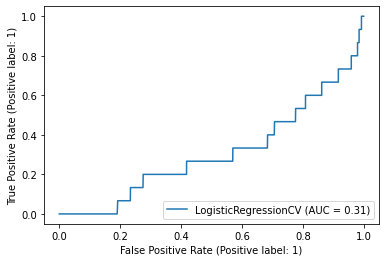

In [96]:
#from this ROC curve we can see that our model performs horribly with true positive rates
RocCurveDisplay.from_estimator(logit_lasso, x1_test, y1_test)

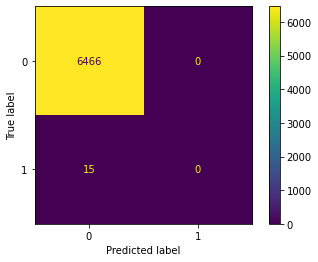

In [97]:
ConfusionMatrixDisplay.from_estimator(logit_lasso, x1_test, y1_test)

### In order to correct for these issues it may be smart to deal with the large imbalance within the training data. To do so we will use a combination of resampling and imputation to create new positive values